In [8]:
##코랩실행시 google driver mount 하기
#from google.colab import drive
#drive.mount('/content/drive')
#% cd /content/drive/My Drive/FAS


In [280]:
!pip install pydicom
!pip install imgaug
!pip install tensorflow
!pip install tqdm

     |████████████████████████████████| 70 kB 834 kB/s eta 0:00:011


In [1]:
import pydicom as pdc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import glob
import pydicom as pdc
from keras.utils import to_categorical
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
#import tensorflow_hub as hub
from skimage import exposure
import webhook   
%pylab inline

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU') # gpus[번호바꿔서 사용 0-3번]
#tf.debugging.set_log_device_placement(True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#path = './metadata/'
path = '../Diagnosis_Gallbladder_Cancer/metadata/'
# Load Meta-data and preprocessing
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index)
patient_meta = patient_meta.drop(patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index, axis=0)
patient_meta.reset_index(drop=True, inplace=True)

# categorical Variables(Sex, Phase)
# pd.get_dummies() 가변수 만들기
# Phase feature 는 제거
patient_meta = pd.concat([patient_meta, pd.get_dummies(patient_meta[['SEX']])], axis=1)
patient_meta = patient_meta.drop(['SEX','PHASE'], axis=1)

# Continuous Variables(Age)
age = patient_meta['AGE'].values
age_scaled = preprocessing.scale(age)
 
patient_meta['AGE_NORM'] = age_scaled
patient_meta = patient_meta.drop(['AGE'], axis = 1)

#Label Setting
# 0 : Metastasis, 56
# 1 : Hepatocelluar Carcinoma, 30
# 2 : cholangiocarcinoma, 14 --> ????    # 숫자가 의미하는 것은??
for r in range(patient_meta.shape[0]):
    if('metastasis' in patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 0
    elif('HCC' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 1
    elif('cholangiocarcinoma' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 2
    else:
        patient_meta.iloc[r, 1] = -1

patient_meta = np.array(patient_meta)   #넘파이 배열로 변환

Drop: Int64Index([42, 66, 69], dtype='int64')


In [3]:
path = '../Diagnosis_Gallbladder_Cancer/metadata/'
# Load Meta-data and preprocessing
patient_dx = pd.read_csv(path + 'patient_meta.csv')
patient_dx = patient_dx[['RANDOM_PT_NO',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_dx[(patient_dx['DX']=='lymphoma') | (patient_dx['DX']=='NET')].index)
patient_dx = patient_dx.drop(patient_dx[(patient_dx['DX']=='lymphoma') | (patient_dx['DX']=='NET')].index, axis=0)
patient_dx.reset_index(drop=True, inplace=True)

def find_disease(patient_no):
    dx=np.array(patient_dx[patient_dx['RANDOM_PT_NO'] == patient_no]['DX'])[0]
    if 'metastasis'in dx:
        return 1
    elif dx == 'HCC':
        return 2
    elif dx == 'cholangiocarcinoma':
        return 3
    else:
        print(f"input error: wrong patient number {patient_no}")

Drop: Int64Index([42, 66, 69], dtype='int64')


In [4]:
# 데이터 전처리 중간 점검
patient_meta

array([['SN00180816', 1, 0, 1, -0.9717086332456366],
       ['SN00361989', 1, 1, 0, -1.0655029028639413],
       ['SN00481545', 2, 1, 0, 0.9041767591204574],
       ['SN00493709', 2, 0, 1, 0.43520541102893384],
       ['SN00181638', 0, 0, 1, -0.31514874591750375],
       ['SN00222863', 0, 0, 1, 0.15382260217401975],
       ['SN00283964', 0, 0, 1, 0.997971028738762],
       ['SN00304545', 0, 1, 0, 0.9041767591204574],
       ['SN00450700', 2, 1, 0, 0.7165882198838479],
       ['SN00508749', 1, 0, 1, 0.997971028738762],
       ['SN00090078', 0, 1, 0, -0.03376593706258964],
       ['SN00369027', 0, 1, 0, -0.31514874591750375],
       ['SN00474278', 0, 1, 0, -1.44067998133716],
       ['SN00305004', 0, 1, 0, -1.3468857117188553],
       ['SN00508618', 0, 0, 1, 0.997971028738762],
       ['SN00067936', 0, 1, 0, -2.4724169471385116],
       ['SN00381399', 2, 0, 1, -0.6903258243907225],
       ['SN00407113', 1, 1, 0, 1.0917652983570667],
       ['SN00097002', 1, 0, 1, 1.3731481072119809],
   

In [5]:
label_df = pd.read_csv('../Diagnosis_Gallbladder_Cancer/metadata/label_df.csv')
#label_df = pd.read_csv('metadata/label_df.csv')
label_df.head()

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


- Z축을 5만큼 잘라서 작업
- Clahe 전처리를 시켜주고, resize는 normalize 후 처리해준다 ( resize = (64,64) )

In [6]:
pwd

'/home/niausr/Kyoung'

In [6]:
# 1 patient 당 DX list 가져오기
# sliding-window Proprocessing (길이가 다른 z 축데이터를 동일하게 만들어준다.)
window_size = 5
size = (256,256)
n_ct_statistics=[]
path = '../Diagnosis_Gallbladder_Cancer/benchmark_liver_tumor/raw/'
# 1 patient 당 DX list 가져오기
grouped_df=label_df.groupby('patient_no').agg(list)

# 10-cv Settings
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for tr_list, te_list in kf.split(patient_meta):
    # Train Dataset
    X_p_tr, X_m_tr, X_i_tr, Y_tr = [], [], [], []
    for tr_idx in tr_list:
        patient_no = patient_meta[tr_idx, 0]
        X_i_tr_ct_list =  sorted(glob.glob(path+patient_no+'/*.dcm'))
        n_ct = len(X_i_tr_ct_list)
        n_ct_statistics.append(n_ct)
        
        # Load 3D CT Data per Patient
        label_block = np.zeros(shape=(n_ct)) # annotation label
        label_block[:] = find_disease(patient_no)
              
        ct_block = [] #사진
        for z in range(n_ct):
            ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
            #ct_block.append(cv2.normalize(cv2.resize(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        ct_block = np.array(ct_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_tr_buffer = []
        Y_i_tr_buffer = []
        #DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            X_i_tr_buffer.append(ct_block[z:z+window_size]) # buffer에 겹쳐서 들어감
            X_p_tr.append(patient_no)# patient number
            X_m_tr.append(patient_meta[tr_idx, 2:])   #meta 정보 전체
            maxVal = np.max(label_block[z:z+window_size])
            Y_i_tr_buffer.append(maxVal) #buffer에 annotation 겹쳐서 들어감
        X_i_tr_buffer = np.array(X_i_tr_buffer)
        X_i_tr.extend(X_i_tr_buffer)
        Y_i_tr_buffer = np.array(Y_i_tr_buffer)
        Y_tr.extend(Y_i_tr_buffer)
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.array(X_p_tr), np.array(X_m_tr), np.array(X_i_tr), np.array(Y_tr)
    print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
    # patient number, meta정보, window size 갯수만큼 겹쳐진 CT 사진, window 마다 y값(max함)
    # Test Dataset
    X_p_te, X_m_te, X_i_te, Y_te = [], [], [], []
    for te_idx in te_list:
        patient_no = patient_meta[te_idx, 0]
        X_i_te_ct_list =  sorted(glob.glob(path+patient_no+'/*.dcm'))
        n_ct = len(X_i_te_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        label_block = np.zeros(shape=(n_ct)) # annotation label
        label_block[:] = find_disease(patient_no)
        
        ct_block = []
        for z in range(n_ct):
            ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_te_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
            #ct_block.append(cv2.normalize(cv2.resize(pdc.dcmread(X_i_te_ct_list[z]).pixel_array, dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        ct_block = np.array(ct_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_te_buffer = []
        Y_i_te_buffer = []
        DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            X_i_te_buffer.append(ct_block[z:z+window_size])
            X_p_te.append(patient_no)
            X_m_te.append(patient_meta[te_idx, 2:])
            maxVal = np.max(label_block[z:z+window_size])
            Y_i_te_buffer.append(maxVal) #buffer에 annotation 겹쳐서 들어감
        X_i_te_buffer = np.array(X_i_te_buffer)
        X_i_te.extend(X_i_te_buffer)
        Y_i_te_buffer = np.array(Y_i_te_buffer)
        Y_te.extend(Y_i_te_buffer)
    X_p_te, X_m_te, X_i_te, Y_te = np.array(X_p_te), np.array(X_m_te), np.array(X_i_te), np.array(Y_te)
    print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
    # patient number, meta정보, window size 갯수만큼 겹쳐진 CT 사진, window 마다 y값(max함)
    break

(10758,) (10758, 3) (10758, 5, 256, 256) (10758,)
(2649,) (2649, 3) (2649, 5, 256, 256) (2649,)


In [7]:
# Random split : Train : 70%
X_p = np.concatenate((X_p_tr, X_p_te), axis=0)
X_m = np.concatenate((X_m_tr, X_m_te), axis=0)
X_i = np.concatenate((X_i_tr, X_i_te), axis=0)
Y = np.concatenate((Y_tr, Y_te), axis=0)

from sklearn.model_selection import train_test_split

X_i_tr, X_i_te, Y_tr, Y_te = train_test_split(X_i,Y, test_size =0.3, random_state=42)
X_m_tr, X_m_te, Y_tr, Y_te = train_test_split(X_m,Y, test_size =0.3, random_state=42)
X_p_tr, X_p_te, Y_tr, Y_te = train_test_split(X_p,Y, test_size =0.3, random_state=42)

In [8]:
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)

(9384,) (9384, 3) (9384, 5, 256, 256) (9384,)
(4023,) (4023, 3) (4023, 5, 256, 256) (4023,)


In [9]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr[Y_tr==1]), len(Y_tr[Y_tr==2]), len(Y_tr[Y_tr==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

0 6163 1989 1232
0 2668 845 510


In [10]:
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)

(9384,) (9384, 3) (9384, 5, 256, 256) (9384,)
(4023,) (4023, 3) (4023, 5, 256, 256) (4023,)


In [11]:
# Save Dataset
#path = './benchmark_liver_tumor/raw/'
path = './np_nonROI/'
np.save(path+'X_p_tr_final', X_p_tr), np.save(path+'X_m_tr_final', X_m_tr), np.save(path+'X_i_tr_final', X_i_tr), np.save(path+'Y_tr_final', Y_tr)
np.save(path+'X_p_te_final', X_p_te), np.save(path+'X_m_te_final', X_m_te), np.save(path+'X_i_te_final', X_i_te), np.save(path+'Y_te_final', Y_te)

(None, None, None, None)

### 여기서 부터 실행

In [12]:
# Load Dataset
path = './np_nonROI/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final.npy'), np.load(path+'X_m_tr_final.npy', allow_pickle=True), np.load(path+'X_i_tr_final.npy'), np.load(path+'Y_tr_final.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final.npy'), np.load(path+'X_m_te_final.npy', allow_pickle=True), np.load(path+'X_i_te_final.npy'), np.load(path+'Y_te_final.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(9384,) (9384, 3) (9384, 5, 256, 256) (9384,) (9384, 4)
(4023,) (4023, 3) (4023, 5, 256, 256) (4023,) (4023, 4)


In [13]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)

(9384, 256, 256, 5)
(4023, 256, 256, 5)


In [14]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1,1,1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1,1,1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1,1,1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1,1,1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
#h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)


# # Build Meta-data
# dnn_input = tf.keras.Input((X_m_tr.shape[1],))
# h = tf.keras.layers.Dense(6, activation='tanh')(dnn_input)
# dnn_output = tf.keras.layers.Dense(6, activation='tanh')(h)


# # Fusion Model
# concat = tf.keras.layers.Concatenate(axis=-1)([cnn_output, dnn_output])
# h = tf.keras.layers.Dense(128, activation='tanh')(concat)
# h = tf.keras.layers.Dense(64, activation='tanh')(h)
# cnn_dnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
# cnn_meta = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=cnn_dnn_output)
# cnn_meta.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# cnn_meta.summary()



#cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

#display(Image(filename="./Kyoung/Image/cnn.png"))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 5)]     0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 5, 1)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 256, 256, 5, 16)   144       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 128, 128, 5, 16)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 128, 128, 5, 16)   2064      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 64, 5, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 64, 5, 16)     2064  

In [15]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn.fit(X_i_tr, Y_tr_cat, validation_data=(X_i_te, Y_te_cat), epochs=200, batch_size=30, shuffle=True, verbose=2, callbacks=[es])
webhook.send_message_to_slack("Done")

Epoch 1/200
313/313 - 44s - loss: 0.7961 - accuracy: 0.6776 - val_loss: 0.4948 - val_accuracy: 0.7982
Epoch 2/200
313/313 - 47s - loss: 0.1324 - accuracy: 0.9558 - val_loss: 0.0153 - val_accuracy: 0.9985
Epoch 3/200
313/313 - 48s - loss: 0.0066 - accuracy: 0.9993 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 4/200
313/313 - 51s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/200
313/313 - 49s - loss: 7.1246e-04 - accuracy: 1.0000 - val_loss: 7.0651e-04 - val_accuracy: 1.0000
Epoch 6/200
313/313 - 49s - loss: 4.3921e-04 - accuracy: 1.0000 - val_loss: 4.8433e-04 - val_accuracy: 1.0000
Epoch 7/200
313/313 - 50s - loss: 2.9843e-04 - accuracy: 1.0000 - val_loss: 3.5668e-04 - val_accuracy: 1.0000
Epoch 8/200
313/313 - 50s - loss: 2.1601e-04 - accuracy: 1.0000 - val_loss: 2.6452e-04 - val_accuracy: 1.0000
Epoch 9/200
313/313 - 48s - loss: 1.6295e-04 - accuracy: 1.0000 - val_loss: 2.1552e-04 - val_accuracy: 1.0000


'send message!'

In [16]:
cnn.evaluate(X_i_te,Y_te_cat)

126/126 [==============================] - 5s 38ms/step - loss: 0.0012 - accuracy: 1.0000


[0.0011520691914483905, 1.0]

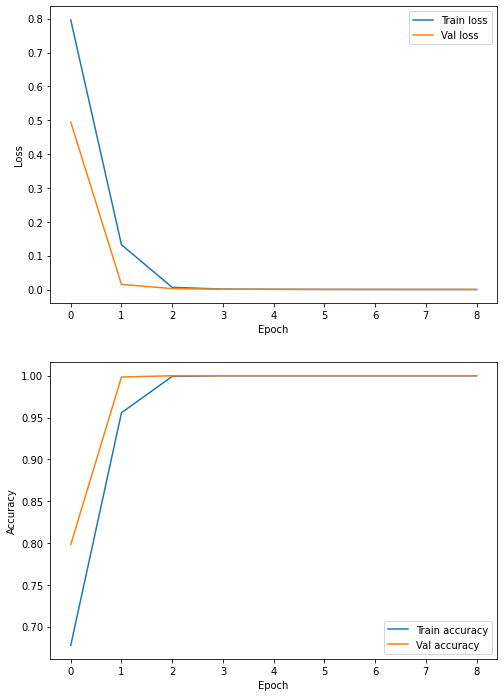

In [17]:
# visualize history
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

### 모델 저장 및 로딩 

In [43]:
# save model
cnn.save("./models/basic_3D_cnn3_nonROI.h5")

# model load하는 경우
cnn  = tf.keras.models.load_model("./models/basic_3D_cnn3_nonROI.h5")

## Confusion Matrix
- X train을 통한 메트릭스
- X test를 통한 메트릭스

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [20]:
def output_class(x):
    output = np.argmax(x)
    #if output == 0:
    #    return 'non-ROI'
    if output == 1:
        return 'metastasis'
    elif output == 2:
        #print(x)
        return 'HCC'
    elif output == 3:
        return 'cholangiocarcinoma'

In [21]:
# X_train을 통한 예측값 비교
y_pred = cnn.predict(X_i_tr)
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[1989    0    0]
 [   0 1232    0]
 [   0    0 6163]]
                    precision    recall  f1-score   support

               HCC       1.00      1.00      1.00      1989
cholangiocarcinoma       1.00      1.00      1.00      1232
        metastasis       1.00      1.00      1.00      6163

          accuracy                           1.00      9384
         macro avg       1.00      1.00      1.00      9384
      weighted avg       1.00      1.00      1.00      9384



In [25]:
y_pred = cnn.predict(X_i_tr)
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
pd.DataFrame(confusion_matrix(y_true, y_pred_classified),columns=sorted(['metastasis','HCC','cholangiocarcinoma']),index=sorted(['metastasis','HCC','cholangiocarcinoma']))

,HCC,cholangiocarcinoma,metastasis
HCC,1989,0,0
cholangiocarcinoma,0,1232,0
metastasis,0,0,6163


In [24]:
# X test 를 이용한 Y 값 예측    
y_pred = cnn.predict(X_i_te)    
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[ 845    0    0]
 [   0  510    0]
 [   0    0 2668]]
                    precision    recall  f1-score   support

               HCC       1.00      1.00      1.00       845
cholangiocarcinoma       1.00      1.00      1.00       510
        metastasis       1.00      1.00      1.00      2668

          accuracy                           1.00      4023
         macro avg       1.00      1.00      1.00      4023
      weighted avg       1.00      1.00      1.00      4023



In [26]:
y_pred = cnn.predict(X_i_te)
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
pd.DataFrame(confusion_matrix(y_true, y_pred_classified),columns=sorted(['metastasis','HCC','cholangiocarcinoma']),index=sorted(['metastasis','HCC','cholangiocarcinoma']))

,HCC,cholangiocarcinoma,metastasis
HCC,845,0,0
cholangiocarcinoma,0,510,0
metastasis,0,0,2668


## Grad-CAM

In [44]:
print(cnn.predict(X_i_tr)[0])

[2.6099315e-05 9.9872547e-01 7.3314534e-04 5.1532424e-04]


In [28]:
y_pred = cnn.predict(X_i_te)

In [29]:
output = np.argmax(y_pred[0])

In [30]:
output

1

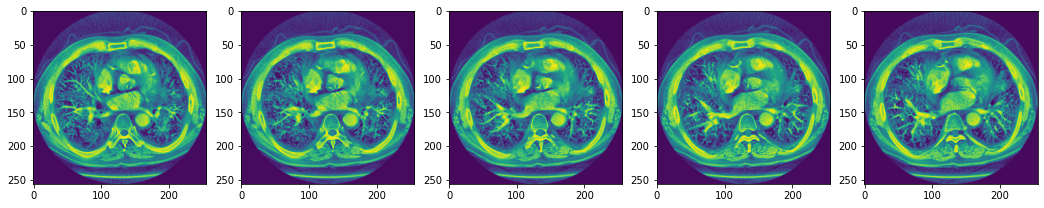

In [45]:
f, ax = plt.subplots(1,5,figsize=(18,8)) 

for i in range(5): 
    X_i_te[0][:,:,i].shape
    img = X_i_te[16][:,:,i]
    img = np.expand_dims(img, axis=2)
    #img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  # 2차원 배열을 3차원으로 3번 복사 
    img.shape
    
    ax[i].imshow(img)

In [46]:
def resize_image_with_crop_or_pad(image, img_size=(256, 256, 5), **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.
    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad
    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer], to_padding, **kwargs)

In [56]:
import SimpleITK as sitk
image_number = 34
image = X_i_te[image_number]
output = cnn.predict(np.expand_dims(image,0))
CLASS_INDEX= np.argmax(output)  #Index of class 
print(CLASS_INDEX)


model = tf.keras.models.load_model("./models/basic_3D_cnn3_nonROI.h5")  #Trained Model
LAYER_NAME = 'conv3d_3'

resized_img=resize_image_with_crop_or_pad(image=image,img_size=(256,256,5),mode='symmetric')
io_img=tf.expand_dims(resized_img, axis=-1)
#print(io_img.shape)
io_img=tf.expand_dims(io_img, axis=0)
#print(io_img.shape)

# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

###--Compute GRADIENT
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(io_img)
    loss = predictions[:, CLASS_INDEX]

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

1


<ipython-input-46-3690fd995db4>:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad(image[slicer], to_padding, **kwargs)


In [57]:
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1,2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]
    
#cam.shape, weights.shape, output[:, :, :, 0].shape

In [58]:
resized_img.shape

(256, 256, 5)

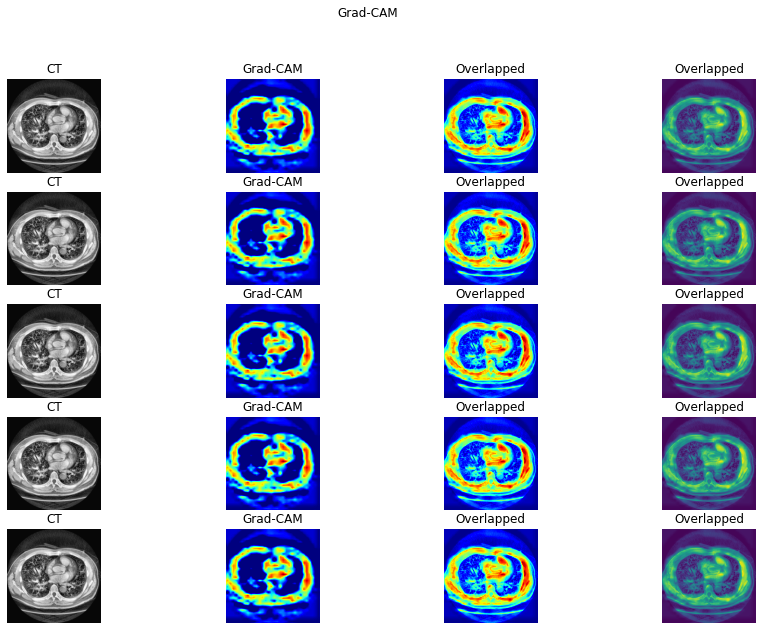

In [60]:
from skimage.transform import resize
from matplotlib import pyplot as plt
capi=resize(cam,(256,256,5))
#print(capi.shape)
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())

f, axarr = plt.subplots(5,4,figsize=(15,10));
f.suptitle('Grad-CAM')
# slice_count=63
# slice_count2=63
for i in range(5):
    #axial_ct_img=np.squeeze(resized_img[slice_count, :,:])
    #axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])

    img_plot = axarr[i,0].imshow(resized_img[:,:,0], cmap='gray');
    axarr[i,0].axis('off')
    axarr[i,0].set_title('CT')


    img_plot = axarr[i,1].imshow(heatmap[:,:,0], cmap='jet');
    axarr[i,1].axis('off')
    axarr[i,1].set_title('Grad-CAM')

    result = resized_img[:,:,0] + heatmap[:,:,0]
    img_plot = axarr[i,2].imshow(result,cmap='jet');
    axarr[i,2].axis('off')
    axarr[i,2].set_title('Overlapped')

    weighted=cv2.addWeighted(resized_img[:,:,0],1,heatmap[:,:,0], 1, 0,)
    img_plot = axarr[i,3].imshow(weighted);
    axarr[i,3].axis('off')
    axarr[i,3].set_title('Overlapped')
    


Found bbox (0, 8, 64, 40)
Found bbox (0, 8, 64, 38)
Found bbox (0, 8, 40, 36)
Found bbox (1, 8, 64, 37)
Found bbox (2, 8, 61, 33)
Found bbox (2, 12, 64, 39)
Found bbox (2, 8, 26, 33)
Found bbox (14, 10, 31, 15)
Found bbox (25, 12, 34, 16)
Found bbox (11, 8, 12, 9)
Found bbox (32, 10, 33, 11)
Found bbox (3, 9, 62, 38)
Found bbox (9, 9, 63, 37)
Found bbox (0, 10, 26, 13)
Found bbox (57, 35, 63, 36)
Found bbox (14, 11, 16, 13)
Found bbox (3, 24, 5, 25)
Found bbox (3, 32, 5, 33)
Found bbox (13, 9, 33, 13)
Found bbox (8, 10, 9, 11)
Found bbox (3, 25, 5, 26)
Found bbox (3, 11, 33, 32)
Found bbox (28, 13, 29, 14)
Found bbox (24, 11, 25, 12)
Found bbox (59, 33, 61, 34)
Found bbox (10, 9, 11, 10)
Found bbox (58, 34, 62, 35)
Found bbox (3, 30, 5, 31)
Found bbox (30, 10, 31, 11)
Found bbox (3, 26, 5, 27)
Found bbox (8, 12, 9, 13)
Found bbox (59, 37, 61, 38)
Found bbox (14, 11, 15, 12)
Found bbox (3, 29, 5, 30)
Found bbox (3, 10, 10, 28)
Found bbox (12, 9, 13, 10)
Found bbox (26, 10, 27, 11)
Found

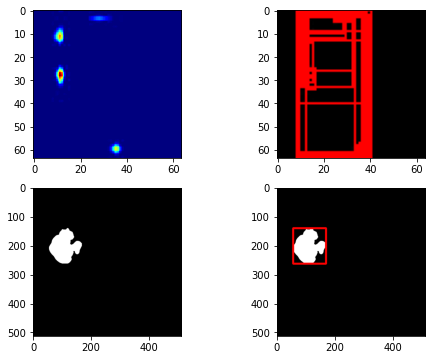

In [53]:
from cv2 import imwrite
from skimage.measure import compare_ssim
from matplotlib.patches import Rectangle
from skimage.measure import label, regionprops
from PIL import Image

IMG_PATH = '../Diagnosis_Gallbladder_Cancer/benchmark_liver_tumor/raw/SN00017916/label/Tumor_0035.png'
img2 = heatmap[:,:,0]

f, ax = plt.subplots(2,2,figsize=(8,6));

img2 = np.expand_dims(img2, axis=2)
img = tf.keras.preprocessing.image.array_to_img(img2)
img.save('test.jpg')
img_test = cv2.imread('test.jpg')
ax[0,0].imshow(img_test[:,:,0], cmap='jet') # (64, 64, 1)
 
props = regionprops(img_test[:,:,0])

#cv2.rectangle(img_test, (props[10].bbox[1], props[10].bbox[0]), (props[10].bbox[3], props[10].bbox[2]), (255, 0, 0), 1)
for prop in props:
        print('Found bbox', prop.bbox)
        #print(prop.bbox[0],prop.bbox[1],prop.bbox[2],prop.bbox[3])
        cv2.rectangle(img_test, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 1)
        

ax[0,1].imshow(img_test,cmap='jet')

img_label = cv2.imread(IMG_PATH)
props_1 = regionprops(img_label[:,:,0])
ax[1,0].imshow(img_label)


for prop in props_1:
        print('Found bbox', prop.bbox)
        #print(prop.bbox[0],prop.bbox[1],prop.bbox[2],prop.bbox[3])
        cv2.rectangle(img_label, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 5)
        
ax[1,1].imshow(img_label,cmap='jet')
       

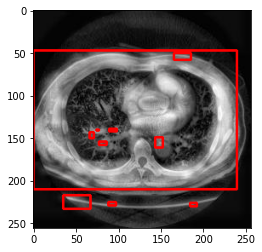

In [65]:
img = heatmap[:,:,0]
#img = result
#img = weighted
img = np.expand_dims(img, axis=2)
img = tf.keras.preprocessing.image.array_to_img(img)
img.save('test.jpg',cmap = 'jet')
img_test = cv2.imread('test.jpg')

img_overlapped = weighted
img_overlapped = np.expand_dims(img_overlapped, axis=2)
img_overlapped = tf.keras.preprocessing.image.array_to_img(img_overlapped)
img_overlapped.save('overlapped.jpg')
img_overlapped = cv2.imread('overlapped.jpg')

gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img_overlapped, (x, y), (x + w, y + h), (255, 0, 0), 2)

#plt.imshow(thresh)
#weighted = np.expand_dims(weighted, axis=2)
#output = weighted + img_test
#weighted.shape, img_test.shape, output.shape
plt.imshow(img_overlapped, cmap = 'jet')